In [1]:
# !python -m spacy download en_core_web_sm

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")
np.random.seed(42)
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
training = pd.read_csv("twitter_training.csv")
training.head()

2401  ... im getting on borderlands and i will murder you all ,
0  2401  ...  I am coming to the borders and I will kill you...   
1  2401  ...  im getting on borderlands and i will kill you ...   
2  2401  ...  im coming on borderlands and i will murder you...   
3  2401  ...  im getting on borderlands 2 and i will murder ...   
4  2401  ...  im getting into borderlands and i can murder y...   

[5 rows x 4 columns]

In [4]:
testing = pd.read_csv("twitter_test.csv")
testing.head()

3364  ... I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣
0   352  ...  BBC News - Amazon boss Jeff Bezos rejects clai...                                                                                                                                                                                                
1  8312  ...  @Microsoft Why do I pay for WORD when it funct...                                                                                                                                                                                                
2  4371  ...  CSGO matchmaking is so full of closet hacking,...                                                                                                                                                                                                
3  4433  ...  Now the President is slapping Americans in the...                                                                                                                                                                                                
4  6273  ...  Hi @EAHelp I’ve had Madeleine McCann in my cel...                                                                                                                                                                                                

[5 rows x 4 columns]

In [5]:
training.columns = ["id", "organization", "label", "tweet"]
testing.columns = ["id", "organization", "label", "tweet"]

In [6]:
training.head(10)

id  ...                                              tweet
0  2401  ...  I am coming to the borders and I will kill you...
1  2401  ...  im getting on borderlands and i will kill you ...
2  2401  ...  im coming on borderlands and i will murder you...
3  2401  ...  im getting on borderlands 2 and i will murder ...
4  2401  ...  im getting into borderlands and i can murder y...
5  2402  ...  So I spent a few hours making something for fu...
6  2402  ...  So I spent a couple of hours doing something f...
7  2402  ...  So I spent a few hours doing something for fun...
8  2402  ...  So I spent a few hours making something for fu...
9  2402  ...  2010 So I spent a few hours making something f...

[10 rows x 4 columns]

In [7]:
testing.head(10)

id  ...                                              tweet
0    352  ...  BBC News - Amazon boss Jeff Bezos rejects clai...
1   8312  ...  @Microsoft Why do I pay for WORD when it funct...
2   4371  ...  CSGO matchmaking is so full of closet hacking,...
3   4433  ...  Now the President is slapping Americans in the...
4   6273  ...  Hi @EAHelp I’ve had Madeleine McCann in my cel...
5   7925  ...  Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
6  11332  ...  Rocket League, Sea of Thieves or Rainbow Six: ...
7   1107  ...  my ass still knee-deep in Assassins Creed Odys...
8   2069  ...  FIX IT JESUS ! Please FIX IT ! What In the wor...
9   3185  ...  The professional dota 2 scene is fucking explo...

[10 rows x 4 columns]

In [8]:
data = pd.concat([training, testing], ignore_index = True)
print(data)

         id  ...                                              tweet
0      2401  ...  I am coming to the borders and I will kill you...
1      2401  ...  im getting on borderlands and i will kill you ...
2      2401  ...  im coming on borderlands and i will murder you...
3      2401  ...  im getting on borderlands 2 and i will murder ...
4      2401  ...  im getting into borderlands and i can murder y...
...     ...  ...                                                ...
75675  4891  ...  ⭐️ Toronto is the arts and culture capital of ...
75676  4359  ...  tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75677  2652  ...  Today sucked so it’s time to drink wine n play...
75678  8069  ...  Bought a fraction of Microsoft today. Small wins.
75679  6960  ...  Johnson & Johnson to stop selling talc baby po...

[75680 rows x 4 columns]


In [9]:
data = data.drop(columns = ["id", "organization"])
data.head(10)

label                                              tweet
0  Positive  I am coming to the borders and I will kill you...
1  Positive  im getting on borderlands and i will kill you ...
2  Positive  im coming on borderlands and i will murder you...
3  Positive  im getting on borderlands 2 and i will murder ...
4  Positive  im getting into borderlands and i can murder y...
5  Positive  So I spent a few hours making something for fu...
6  Positive  So I spent a couple of hours doing something f...
7  Positive  So I spent a few hours doing something for fun...
8  Positive  So I spent a few hours making something for fu...
9  Positive  2010 So I spent a few hours making something f...

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   75680 non-null  object
 1   tweet   74994 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [11]:
data.isnull().sum()

label      0
tweet    686
dtype: int64

In [12]:
data["tweet"].isnull().sum() / data.shape[0]

np.float64(0.009064482029598309)

In [13]:
data = data.dropna()
data.isnull().sum()

label    0
tweet    0
dtype: int64

In [14]:
data.duplicated().sum()

np.int64(4743)

In [15]:
data = data.drop_duplicates(keep = "first")
data.duplicated().sum()

np.int64(0)

In [16]:
data["tweet"] = data["tweet"].str.lower()
data.head(10)

label                                              tweet
0  Positive  i am coming to the borders and i will kill you...
1  Positive  im getting on borderlands and i will kill you ...
2  Positive  im coming on borderlands and i will murder you...
3  Positive  im getting on borderlands 2 and i will murder ...
4  Positive  im getting into borderlands and i can murder y...
5  Positive  so i spent a few hours making something for fu...
6  Positive  so i spent a couple of hours doing something f...
7  Positive  so i spent a few hours doing something for fun...
8  Positive  so i spent a few hours making something for fu...
9  Positive  2010 so i spent a few hours making something f...

In [17]:
data["No_of_characters"] = data["tweet"].apply(len)
data["No_of_words"] = data.apply(lambda row: nltk.word_tokenize(row["tweet"]), axis = 1).apply(len)
data["No_of_sentences"] = data.apply(lambda row: nltk.sent_tokenize(row["tweet"]), axis = 1).apply(len)
data.head(10)

label  ... No_of_sentences
0  Positive  ...               1
1  Positive  ...               1
2  Positive  ...               1
3  Positive  ...               1
4  Positive  ...               1
5  Positive  ...               8
6  Positive  ...               2
7  Positive  ...               1
8  Positive  ...               8
9  Positive  ...               8

[10 rows x 5 columns]

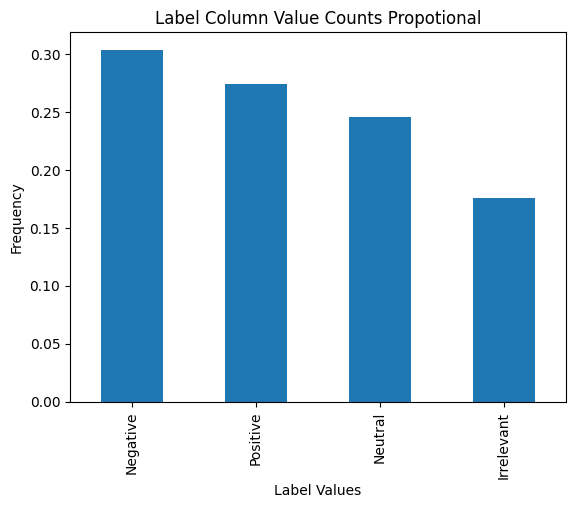

In [18]:
data["label"].value_counts(normalize = True).plot(kind = "bar", title = "Label Column Value Counts Propotional")
plt.xlabel("Label Values")
plt.ylabel("Frequency")
plt.show();

In [19]:
all_text = " ".join(data["tweet"].astype(str))

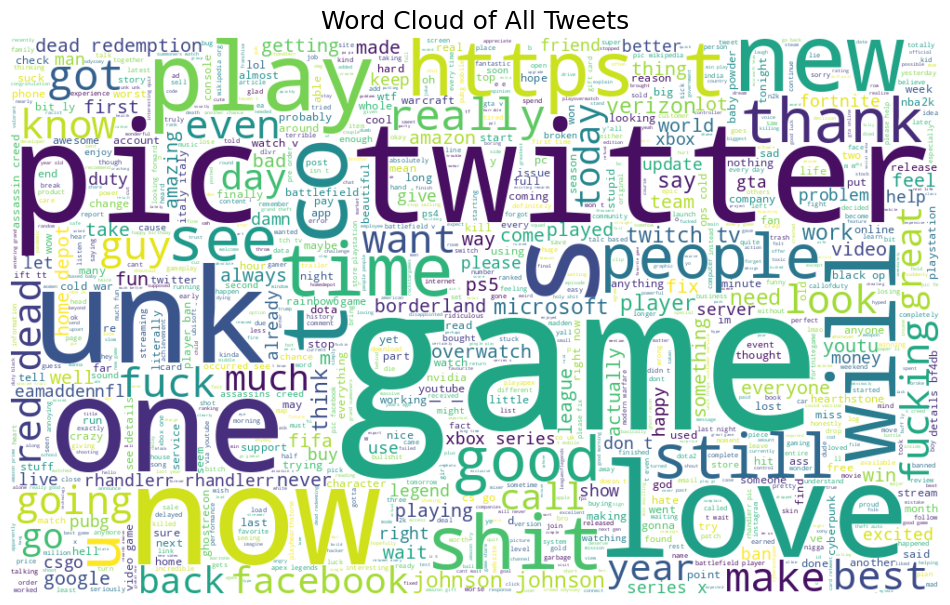

In [20]:
word_cloud = WordCloud(
    width = 1000,
    height = 600,
    background_color = "white",
    colormap = "viridis",
    stopwords = None,
    max_words = 1000
).generate(all_text)

plt.figure(figsize = (12, 8))
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.title('Word Cloud of All Tweets', fontsize=18)
plt.show();

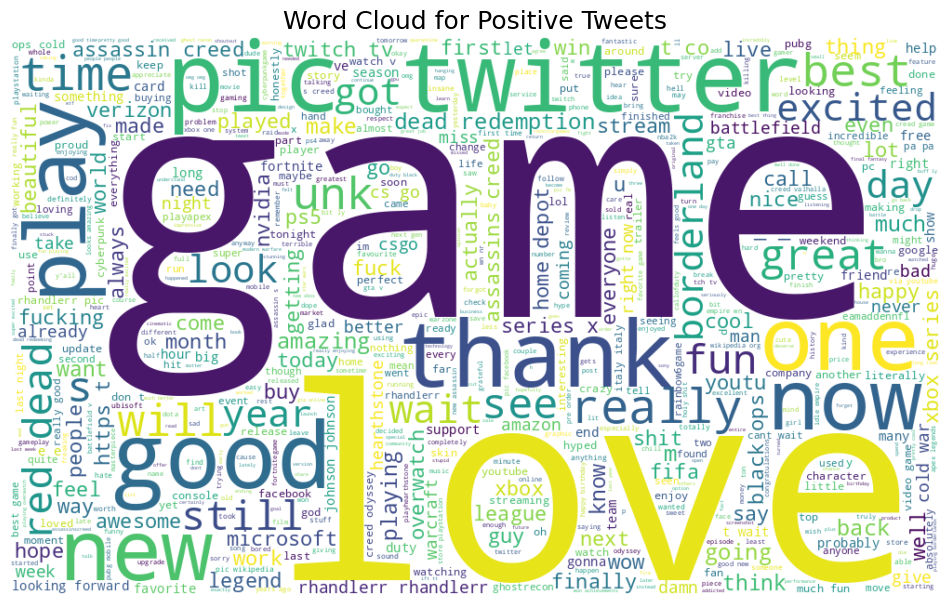

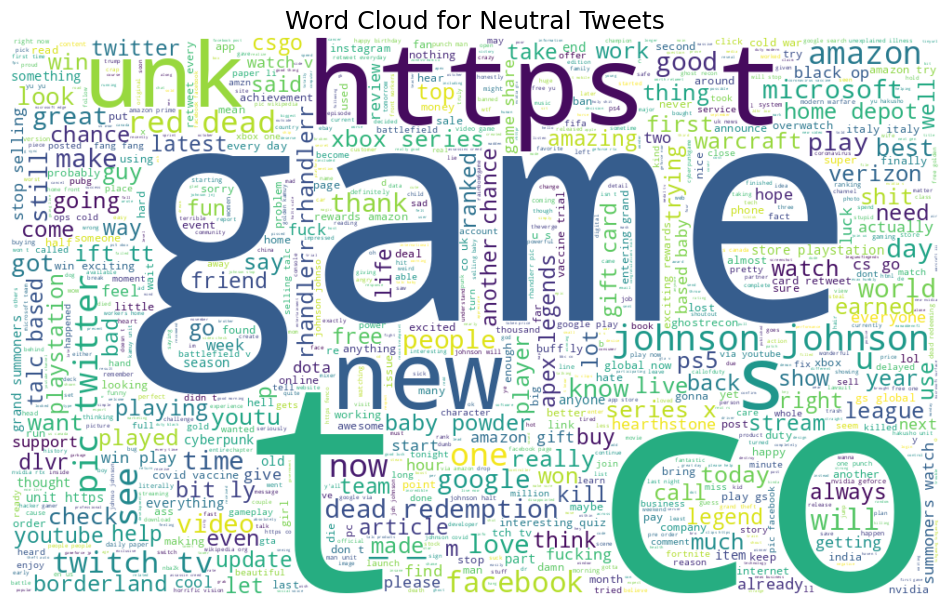

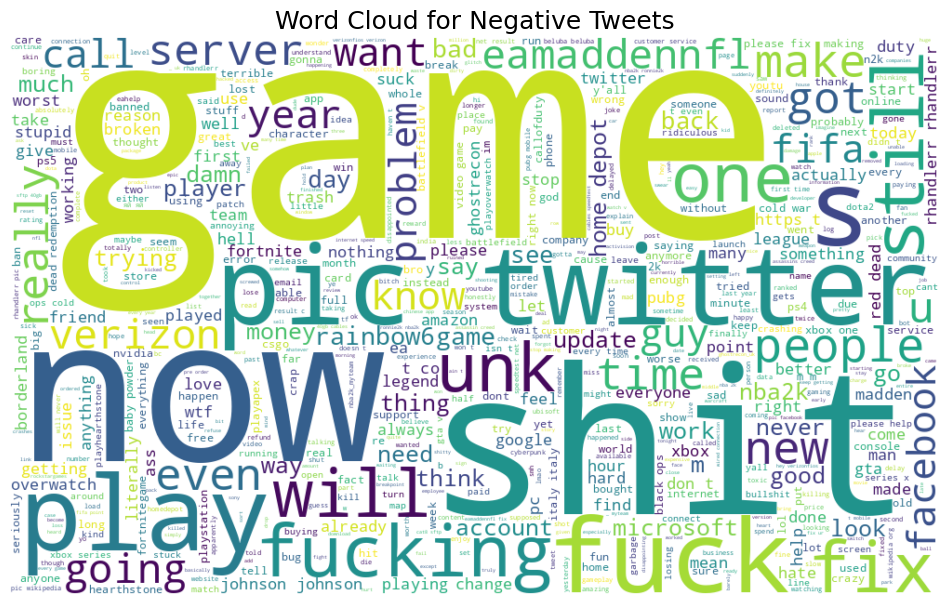

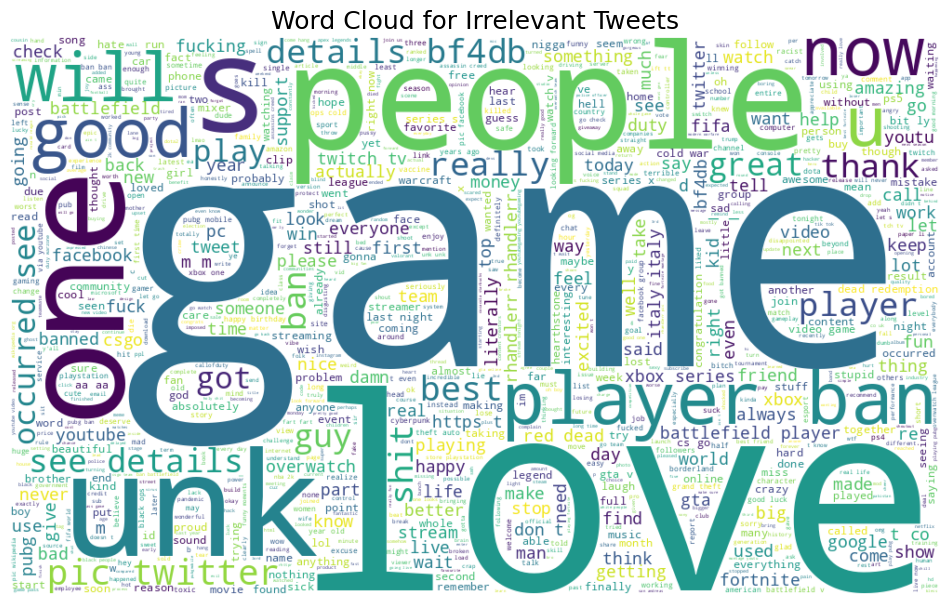

In [21]:
labels = data["label"].unique()

for label in labels:

  subset = data[data["label"] == label]
  text = " ".join(subset["tweet"].astype(str))
  word_cloud = WordCloud(
      width = 1000,
      height = 600,
      background_color= "white",
      colormap = "viridis",
      stopwords = None,
      max_words = 1000
  ).generate(text)

  plt.figure(figsize = (12, 8))
  plt.imshow(word_cloud, interpolation = "bilinear")
  plt.axis('off')
  plt.title(f'Word Cloud for {label} Tweets', fontsize=18)
  plt.show();

In [22]:
data.shape

(70251, 5)

In [23]:
data_with_one_word = data[data["No_of_words"] == 1]
print(len(data_with_one_word))
data_with_one_word.head(10)


482


label  tweet  No_of_characters  No_of_words  No_of_sentences
10     Positive    was                 3            1                1
52      Neutral    all                 3            1                1
190    Positive    why                 3            1                1
202    Negative      i                 1            1                1
388  Irrelevant     is                 2            1                1
430  Irrelevant  there                 5            1                1
454    Positive    one                 3            1                1
466    Positive    can                 3            1                1
484    Positive     of                 2            1                1
514    Positive     it                 2            1                1

In [24]:
data_with_two_words = data[data["No_of_words"] == 2]
print(len(data_with_two_words))
data_with_two_words.head(10)


1015


label             tweet  No_of_characters  No_of_words  No_of_sentences
61    Neutral              .. [                 4            2                1
62    Neutral             .. 45                 5            2                1
64    Neutral           .. what                 7            2                1
253   Neutral     slutsky......                13            2                1
551   Neutral      trying out                  12            2                1
554   Neutral         trying it                 9            2                1
556   Neutral           you out                 7            2                1
747  Positive  series completed                16            2                1
991  Positive         the sweat                 9            2                1
993  Positive         for sweet                 9            2                1

In [25]:
data_with_three_words = data[data["No_of_words"] == 3]
print(len(data_with_three_words))
data_with_three_words.head(10)

1392


label               tweet  ...  No_of_words  No_of_sentences
59     Neutral             . . [    ...            3                3
83    Positive  fuck yessssssss .   ...            3                1
84    Positive      fick yessssss.  ...            3                1
85    Positive    fuck yessssssss.  ...            3                1
88    Positive           fuck you.  ...            3                1
352   Positive               <unk>  ...            3                1
530   Negative          holy week!  ...            3                1
555    Neutral       trying it out  ...            3                1
970   Negative       again and wtf  ...            3                1
1045   Neutral     amazing photos.  ...            3                1

[10 rows x 5 columns]

In [26]:
data = data[data["No_of_words"] > 2]
data.shape

(68750, 5)

In [27]:
stop_words = set(stopwords.words("english"))

negation = {"not", "no", "nor", "never"}

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove <unk> or unk tokens
    text = re.sub(r'(<unk>|unk)', '', text, flags=re.IGNORECASE)

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra white space from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Limit repetitive characters (e.g., "yessss" -> "yess")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Use spaCy for tokenization and lemmatization
    doc = nlp(text)

    # Lemmatize and remove stopwords (except negations)
    words = [
        token.lemma_
        for token in doc
        if (token.text not in stop_words or token.text in negation) and token.is_alpha
    ]

    return " ".join(words)


In [28]:
data["cleaned_tweet"] = data["tweet"].apply(preprocess_text)
data.head(20)

label  ...                                      cleaned_tweet
0   Positive  ...                                   come border kill
1   Positive  ...                                get borderland kill
2   Positive  ...                             come borderland murder
3   Positive  ...                              get borderland murder
4   Positive  ...                              get borderland murder
5   Positive  ...  spend hour make something fun not know huge bo...
6   Positive  ...  spend couple hour something fun not know huge ...
7   Positive  ...  spend hour something fun not know huge borderl...
8   Positive  ...  spend hour make something fun not know huge rh...
9   Positive  ...  spend hour make something fun not know huge rh...
11   Neutral  ...  rockhard la varlope rare powerful handsome jac...
12   Neutral  ...  rockhard la varlope rare powerful handsome jac...
13   Neutral  ...  rockhard la varlope rare powerful handsome jac...
14   Neutral  ...  rockhard la vita rare powerful handsome jackpo...
15   Neutral  ...  live rock hard music la la varlope rare powerf...
16   Neutral  ...  ihard like rare london de handsome borderland ...
17  Positive  ...  first borderland session long time actually re...
18  Positive  ...  first borderland session long time actually re...
20  Positive  ...  first borderland session long time actually en...
21  Positive  ...  first real borderland session nice long wait t...

[20 rows x 6 columns]

In [29]:
data.isnull().sum()

label               0
tweet               0
No_of_characters    0
No_of_words         0
No_of_sentences     0
cleaned_tweet       0
dtype: int64

In [30]:
data.duplicated().sum()

np.int64(207)

In [31]:
data = data.drop_duplicates(keep = "first")
data.duplicated().sum()

np.int64(0)

In [32]:
data = data.drop(columns = ["tweet"], axis = 1)
data.head()

label  No_of_characters  ...  No_of_sentences           cleaned_tweet
0  Positive                51  ...                1        come border kill
1  Positive                50  ...                1     get borderland kill
2  Positive                51  ...                1  come borderland murder
3  Positive                57  ...                1   get borderland murder
4  Positive                53  ...                1   get borderland murder

[5 rows x 5 columns]

In [33]:
data = data[["label", "cleaned_tweet"]]
data.head()

label           cleaned_tweet
0  Positive        come border kill
1  Positive     get borderland kill
2  Positive  come borderland murder
3  Positive   get borderland murder
4  Positive   get borderland murder

In [34]:
X = data["cleaned_tweet"]
y = data["label"]

In [35]:
X_train , X_val , y_train , y_val = train_test_split(X , y , test_size = 0.2 , random_state = 42)
X_val , X_test , y_val , y_test = train_test_split(X_val , y_val , test_size = 0.5 , random_state = 42)

In [36]:
tokens = [tweet.split() for tweet in X_train]

flat_tokens = [word for tweet in tokens for word in tweet]

tf_counts = Counter(flat_tokens)

df_counts = Counter()
for tweet in tokens:
  df_counts.update(set(tweet))

vocab_df = pd.DataFrame({
    "token": list(tf_counts.keys()),
    "tf": list(tf_counts.values()),
    "df": [df_counts[tokens] for tokens in tf_counts.keys()]
})

vocab_df = vocab_df.sort_values(by = "tf", ascending = False).reset_index(drop = True)
print("Top 10 most frequent tokens:\n", vocab_df.head(10))

Top 10 most frequent tokens:
   token     tf     df
0   not  12064  10168
1  game   8209   6825
2   get   6382   5668
3  play   5356   4813
4  good   4591   4282
5    go   4342   3977
6  like   4077   3708
7  make   3101   2884
8   one   2965   2767
9   see   2936   2786


In [37]:
vocab_df["df_ratio"] = vocab_df["df"] / len(X_train)
vocab_df["cum_tf"] = vocab_df["tf"].cumsum()
vocab_df["cum_coverage"] = vocab_df["cum_tf"] / vocab_df["tf"].sum()
vocab_df.head(10)

token     tf     df  df_ratio  cum_tf  cum_coverage
0   not  12064  10168  0.185432   12064      0.019400
1  game   8209   6825  0.124467   20273      0.032601
2   get   6382   5668  0.103367   26655      0.042864
3  play   5356   4813  0.087774   32011      0.051477
4  good   4591   4282  0.078090   36602      0.058860
5    go   4342   3977  0.072528   40944      0.065842
6  like   4077   3708  0.067622   45021      0.072399
7  make   3101   2884  0.052595   48122      0.077385
8   one   2965   2767  0.050461   51087      0.082154
9   see   2936   2786  0.050808   54023      0.086875

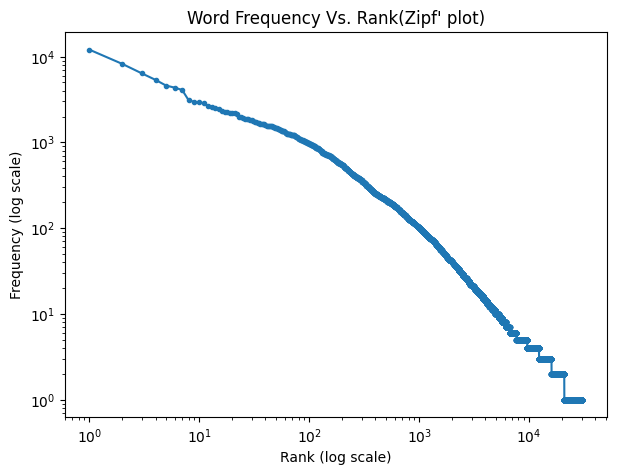

In [38]:
plt.figure(figsize = (7,5))
plt.loglog(range(1, len(vocab_df) + 1), vocab_df["tf"], marker = ".")
plt.title("Word Frequency Vs. Rank(Zipf' plot)")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.show();

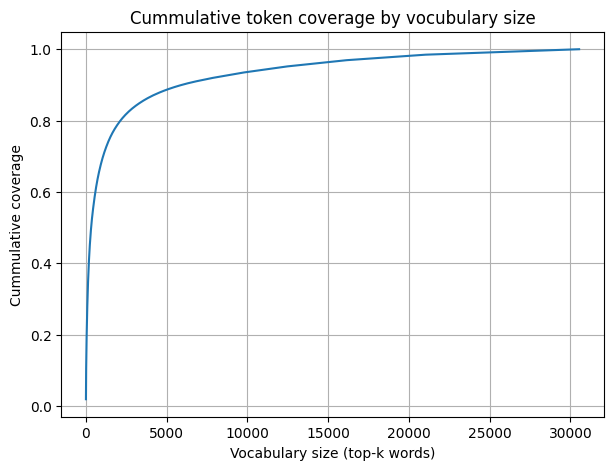

In [39]:
plt.figure(figsize = (7,5))
plt.plot(range(1, len(vocab_df) + 1), vocab_df["cum_coverage"])
plt.title("Cummulative token coverage by vocubulary size")
plt.xlabel("Vocabulary size (top-k words)")
plt.ylabel("Cummulative coverage")
plt.grid(True)
plt.show();

In [40]:
for k in [500, 1000, 5000, 10000, 15000, 20000]:
  coverage = vocab_df.iloc[:k]["cum_coverage"].values[-1]
  print(f"Top {k} tokens cover {coverage*100:.2f}% of total tokens occurance")

Top 500 tokens cover 57.33% of total tokens occurance
Top 1000 tokens cover 69.03% of total tokens occurance
Top 5000 tokens cover 88.65% of total tokens occurance
Top 10000 tokens cover 93.63% of total tokens occurance
Top 15000 tokens cover 96.41% of total tokens occurance
Top 20000 tokens cover 98.17% of total tokens occurance


In [41]:
max_vocab = 10000
BOW = CountVectorizer(max_features = max_vocab, ngram_range= (1, 2))
X_train_bow = BOW.fit_transform(X_train)
X_val_bow = BOW.transform(X_val)
X_test_bow = BOW.transform(X_test)

In [42]:
TF_IDF = TfidfVectorizer(max_features = max_vocab, ngram_range= (1, 2))
X_train_tfidf = TF_IDF.fit_transform(X_train)
X_val_tfidf = TF_IDF.transform(X_val)
X_test_tfidf = TF_IDF.transform(X_test)

In [43]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [52]:
def model_building(model_name, model, word_rep_technique):
  print(f"Model Used: {model_name}")
  print()
  print(f"Word Representation Technique: {word_rep_technique}")
  print()
  model = model()
  if word_rep_technique == "BOW":
    model.fit(X_train_bow, y_train)
    y_pred_train = model.predict(X_train_bow)
    y_pred_val = model.predict(X_val_bow)
    y_pred = model.predict(X_test_bow)
    traing_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Training Accuracy: {traing_acc}")
    print()
    print(f"Validation Accuracy: {val_acc}")
    print()
    print(f"Test Accuracy: {test_acc}")
    print()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print()
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot= True, fmt = "d", cmap = "Blues",
                xticklabels= ["Class 0", "Class 1", "Class 2", "Class 3"],
                yticklabels= ["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show();
  else:
    model.fit(X_train_tfidf, y_train)
    y_pred_train = model.predict(X_train_tfidf)
    y_pred_val = model.predict(X_val_tfidf)
    y_pred = model.predict(X_test_tfidf)
    traing_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Training Accuracy: {traing_acc}")
    print()
    print(f"Validation Accuracy: {val_acc}")
    print()
    print(f"Test Accuracy: {test_acc}")
    print()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print()
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot= True, fmt = "d", cmap = "Blues",
                xticklabels= ["Class 0", "Class 1", "Class 2", "Class 3"],
                yticklabels= ["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show();

Model Used: Logistic Regression

Word Representation Technique: BOW

Training Accuracy: 0.873746215851479

Validation Accuracy: 0.7738546833965567

Test Accuracy: 0.7772428884026258

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1239
           1       0.82      0.83      0.82      2087
           2       0.76      0.74      0.75      1637
           3       0.75      0.81      0.78      1892

    accuracy                           0.78      6855
   macro avg       0.78      0.77      0.77      6855
weighted avg       0.78      0.78      0.78      6855


Confusion Matrix:


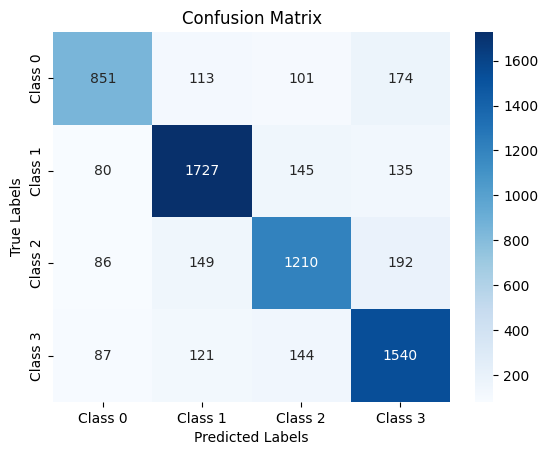

In [53]:
model_building("Logistic Regression", LogisticRegression, "BOW")

Model Used: Logistic Regression

Word Representation Technique: TF-IDF

Training Accuracy: 0.8075464128095707

Validation Accuracy: 0.7318354245695944

Test Accuracy: 0.7307075127644056

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.59      0.65      1239
           1       0.75      0.82      0.78      2087
           2       0.70      0.68      0.69      1637
           3       0.73      0.77      0.75      1892

    accuracy                           0.73      6855
   macro avg       0.73      0.71      0.72      6855
weighted avg       0.73      0.73      0.73      6855


Confusion Matrix:


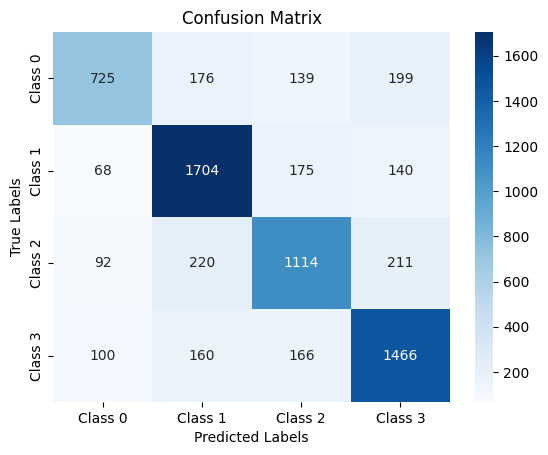

In [54]:
model_building("Logistic Regression", LogisticRegression, "TF-IDF")

Model Used: Random Forest Classifier

Word Representation Technique: BOW

Training Accuracy: 0.9882189882189882

Validation Accuracy: 0.9002042602859645

Test Accuracy: 0.9066374908825675

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1239
           1       0.92      0.94      0.93      2087
           2       0.90      0.90      0.90      1637
           3       0.88      0.92      0.90      1892

    accuracy                           0.91      6855
   macro avg       0.91      0.90      0.90      6855
weighted avg       0.91      0.91      0.91      6855


Confusion Matrix:


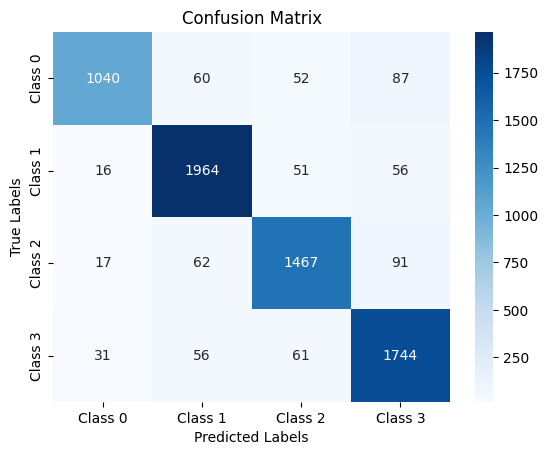

In [55]:
model_building("Random Forest Classifier", RandomForestClassifier, "BOW")

Model Used: Random Forest Classifier

Word Representation Technique: TF-IDF

Training Accuracy: 0.988182514498304

Validation Accuracy: 0.8920338488473883

Test Accuracy: 0.9025528811086798

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1239
           1       0.90      0.95      0.92      2087
           2       0.89      0.89      0.89      1637
           3       0.89      0.91      0.90      1892

    accuracy                           0.90      6855
   macro avg       0.91      0.90      0.90      6855
weighted avg       0.90      0.90      0.90      6855


Confusion Matrix:


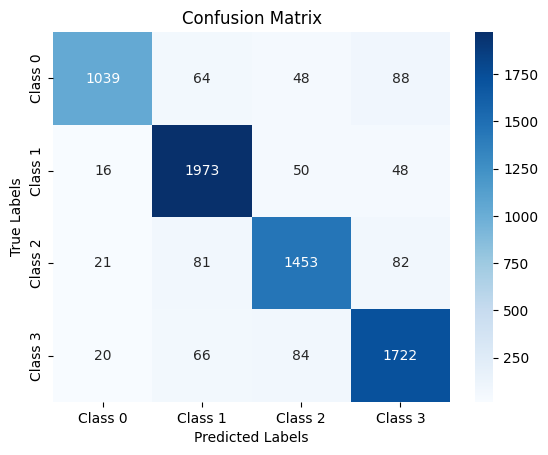

In [56]:
model_building("Random Forest Classifier", RandomForestClassifier, "TF-IDF")

Model Used: K-Nearest Neighbors

Word Representation Technique: BOW

Training Accuracy: 0.9182441550862603

Validation Accuracy: 0.8411146775605486

Test Accuracy: 0.8405543398978848

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1239
           1       0.86      0.89      0.87      2087
           2       0.85      0.81      0.83      1637
           3       0.82      0.84      0.83      1892

    accuracy                           0.84      6855
   macro avg       0.84      0.84      0.84      6855
weighted avg       0.84      0.84      0.84      6855


Confusion Matrix:


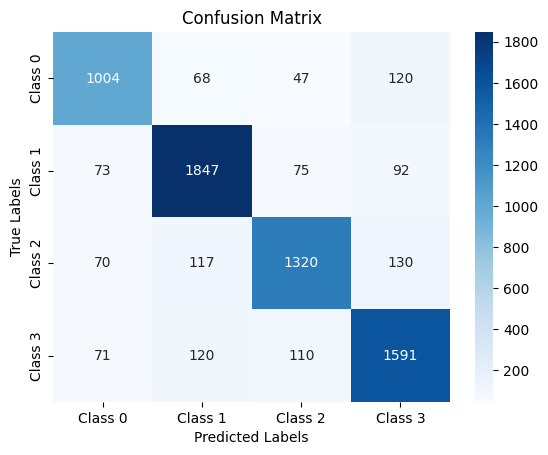

In [58]:
model_building("K-Nearest Neighbors", KNeighborsClassifier, "BOW")

Model Used: K-Nearest Neighbors

Word Representation Technique: TF-IDF

Training Accuracy: 0.9399277820330452

Validation Accuracy: 0.8718996206594689

Test Accuracy: 0.8774617067833698

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1239
           1       0.89      0.91      0.90      2087
           2       0.85      0.89      0.87      1637
           3       0.90      0.84      0.86      1892

    accuracy                           0.88      6855
   macro avg       0.87      0.88      0.88      6855
weighted avg       0.88      0.88      0.88      6855


Confusion Matrix:


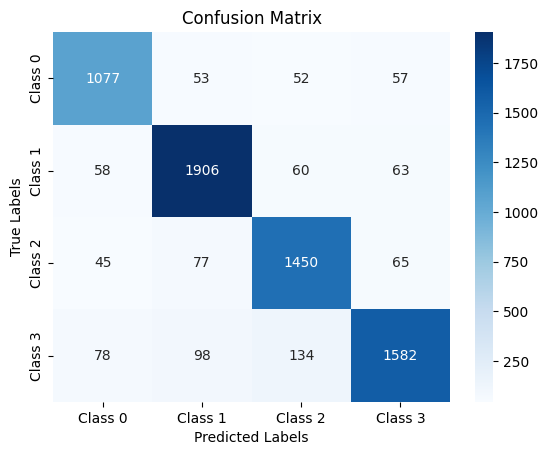

In [59]:
model_building("K-Nearest Neighbors", KNeighborsClassifier, "TF-IDF")

Model Used: Support Vector Machine

Word Representation Technique: BOW

Training Accuracy: 0.9122624648940438

Validation Accuracy: 0.8437408812372338

Test Accuracy: 0.8510576221735959

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1239
           1       0.86      0.92      0.89      2087
           2       0.87      0.81      0.84      1637
           3       0.80      0.89      0.84      1892

    accuracy                           0.85      6855
   macro avg       0.86      0.84      0.84      6855
weighted avg       0.85      0.85      0.85      6855


Confusion Matrix:


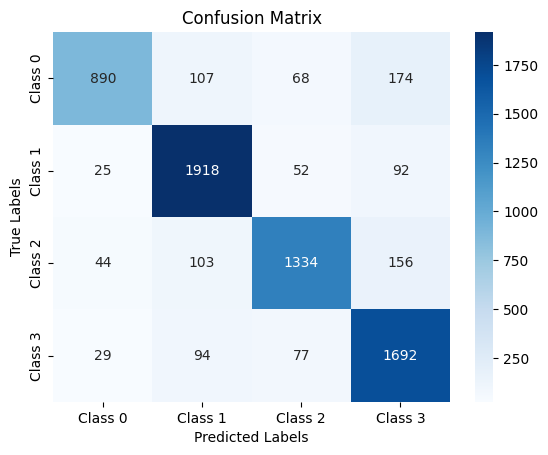

In [60]:
model_building("Support Vector Machine", SVC, "BOW")

Model Used: Multinomial Naive Bayes

Word Representation Technique: BOW

Training Accuracy: 0.723419776051355

Validation Accuracy: 0.6702655383717537

Test Accuracy: 0.6672501823486506

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      1239
           1       0.71      0.75      0.73      2087
           2       0.64      0.54      0.59      1637
           3       0.64      0.76      0.69      1892

    accuracy                           0.67      6855
   macro avg       0.66      0.65      0.65      6855
weighted avg       0.67      0.67      0.66      6855


Confusion Matrix:


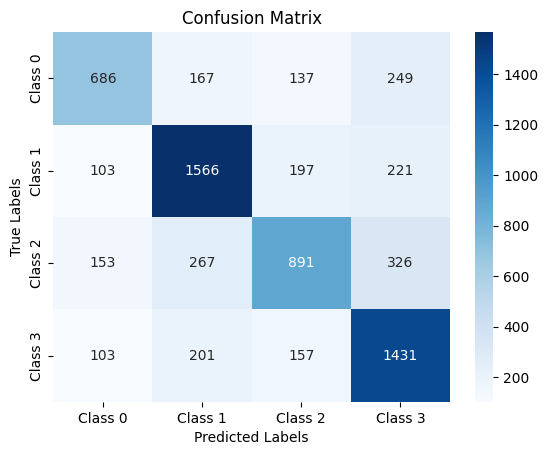

In [61]:
model_building("Multinomial Naive Bayes", MultinomialNB, "BOW")

Model Used: Multinomial Naive Bayes

Word Representation Technique: TF-IDF

Training Accuracy: 0.738191632928475

Validation Accuracy: 0.6810621534870149

Test Accuracy: 0.6777534646243618

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.41      0.54      1239
           1       0.67      0.82      0.74      2087
           2       0.67      0.58      0.62      1637
           3       0.65      0.78      0.71      1892

    accuracy                           0.68      6855
   macro avg       0.70      0.65      0.65      6855
weighted avg       0.69      0.68      0.67      6855


Confusion Matrix:


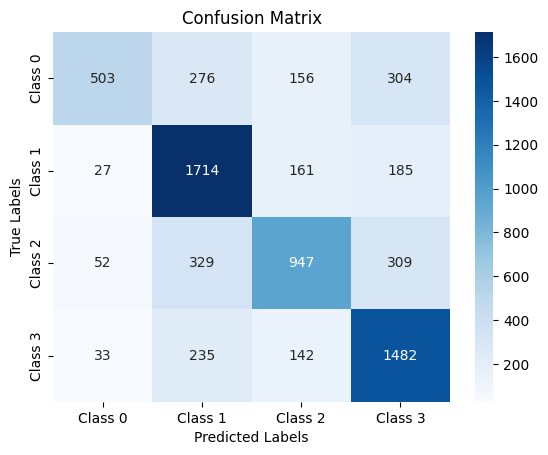

In [62]:
model_building("Multinomial Naive Bayes", MultinomialNB, "TF-IDF")

Model Used: XGBoost

Word Representation Technique: BOW

Training Accuracy: 0.6987817777291462

Validation Accuracy: 0.6397723956813539

Test Accuracy: 0.6433260393873085

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.37      0.49      1239
           1       0.66      0.80      0.72      2087
           2       0.67      0.52      0.59      1637
           3       0.59      0.76      0.66      1892

    accuracy                           0.64      6855
   macro avg       0.66      0.61      0.62      6855
weighted avg       0.66      0.64      0.63      6855


Confusion Matrix:


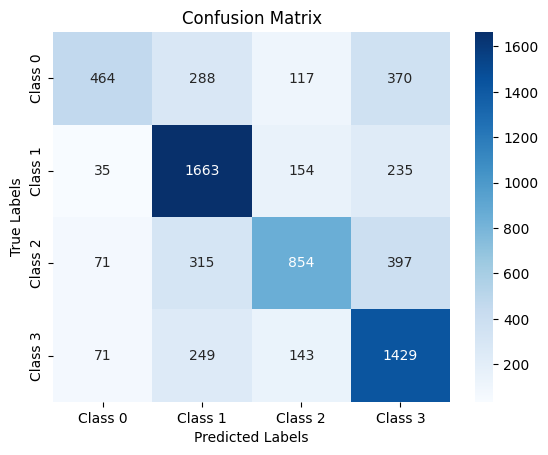

In [63]:
model_building("XGBoost", XGBClassifier, "BOW")

Model Used: XGBoost

Word Representation Technique: TF-IDF

Training Accuracy: 0.7208301418827735

Validation Accuracy: 0.6400641960898745

Test Accuracy: 0.6520787746170679

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.40      0.53      1239
           1       0.62      0.83      0.71      2087
           2       0.67      0.55      0.60      1637
           3       0.65      0.71      0.68      1892

    accuracy                           0.65      6855
   macro avg       0.68      0.62      0.63      6855
weighted avg       0.67      0.65      0.64      6855


Confusion Matrix:


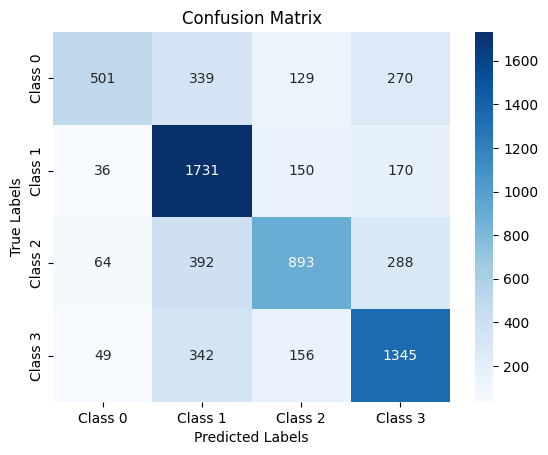

In [64]:
model_building("XGBoost", XGBClassifier, "TF-IDF")